In [1]:
import time
from PIL import Image
import numpy as np

import keras
import keras.backend as K
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [93]:
height = 512
width = 512
R_mean = 103.939
G_mean = 116.779
B_mean = 123.68

# content_weight = 0.025
# style_weight = 5.0
content_weight = 1
style_weight = 100
total_variation_weight = 1.0

In [94]:
content_image_path = 'images/hugo.png'
style_image_path = 'images/styles/wave.png'

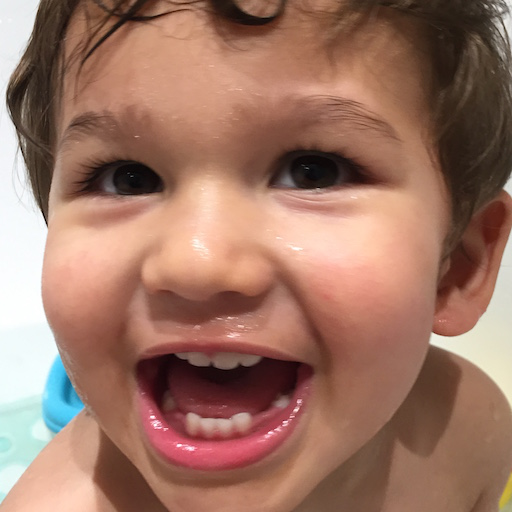

In [95]:
# load content image
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

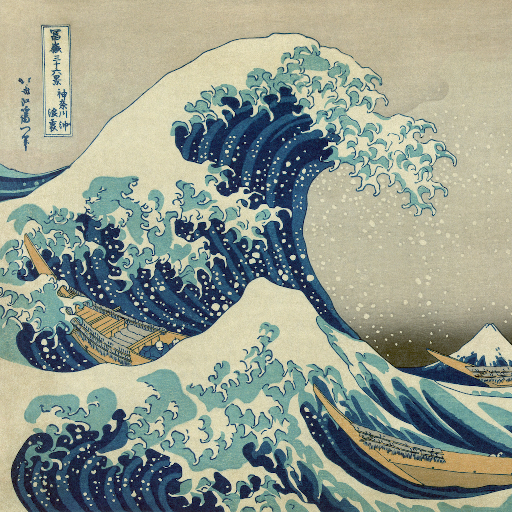

In [96]:
# load style image
style_image = Image.open(style_image_path)
style_image = style_image.resize((height, width))
style_image

In [97]:
# Turn images into arrays and add dimension
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)

# Preprocess images for VGG by subtracting RGB means from VGG paper
content_array[:, :, :, 0] -= R_mean
content_array[:, :, :, 1] -= G_mean
content_array[:, :, :, 2] -= B_mean

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= G_mean
style_array[:, :, :, 2] -= B_mean

# Convert to BGR as in VGG paper
content_array = content_array[:, :, :, ::-1]
style_array = style_array[:, :, :, ::-1]

In [98]:
# Define images as tf variables and create placeholder combination image
content_image = K.variable(content_array)
style_image = K.variable(style_array)
combination_image = K.placeholder((1, height, width, 3))

# Concatenate all three images
input_tensor = K.concatenate([content_image,
                              style_image,
                              combination_image], axis=0)

In [99]:
# Load VGG
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

In [100]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_3/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_3/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_3/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_3/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_3/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_3/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_3/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_3/Relu:0' shape=(3, 64, 64, 51

In [101]:
# Initialize loss to zero
loss = K.variable(0.)

In [102]:
# Define content loss. We use the content feature from block2_conv2 as in Johnson et al. (2016)
def content_loss(content, combination):
    shape = K.shape(content)
    num_weights = K.cast(shape[0] * shape[1] * shape[2], dtype='float32')
    return K.sum(K.square(combination - content)) / (2 * num_weights)

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

In [103]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [104]:
# Define style loss. We use the style features from Johnson et al. (2016)
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
#     channels = 3
#     size = height * width
#     return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return K.sum(K.square(S - C)) / (2 * K.cast(K.shape(style)[2], dtype='float32'))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [105]:
# Add total variation loss (regularization)
def total_variation_loss(x):
    a = K.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [106]:
# Define gradient
grads = K.gradients(loss, combination_image)

In [107]:
# Define Evaluator class to find loss and gradient at the same time.

outputs = [loss]
outputs += grads
f_outputs = K.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [108]:
# Reverse preprocessing on the resulting image to get final result
def reverse_preprocess(img):
    x = img.copy()
    x = x.reshape((height, width, 3))
    x = x[:, :, ::-1] # BGR -> RGB
    x[:, :, 0] += R_mean
    x[:, :, 1] += G_mean
    x[:, :, 2] += B_mean
    x = np.clip(x, 0, 255).astype('uint8')
    return x

('Start of iteration', 0)


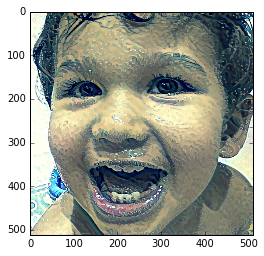

('Current loss value:', 4.063067e+20)
Iteration 1 completed in 20s
('Start of iteration', 1)


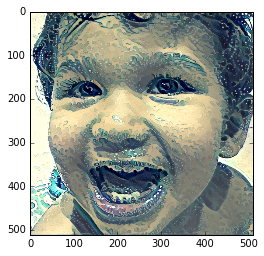

('Current loss value:', 6.820129e+19)
Iteration 2 completed in 21s
('Start of iteration', 2)


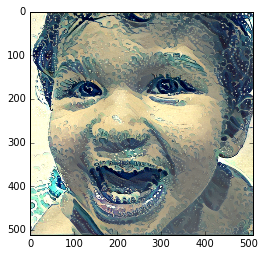

('Current loss value:', 3.0791397e+19)
Iteration 3 completed in 20s
('Start of iteration', 3)


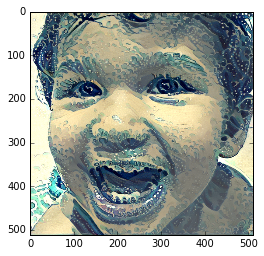

('Current loss value:', 1.8761805e+19)
Iteration 4 completed in 21s
('Start of iteration', 4)


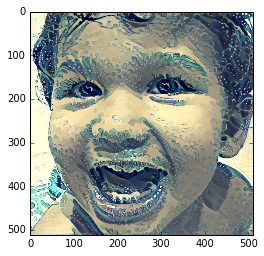

('Current loss value:', 1.3425144e+19)
Iteration 5 completed in 20s
('Start of iteration', 5)


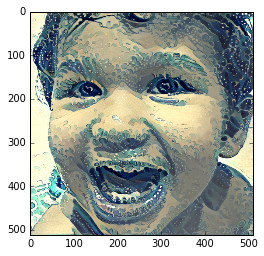

('Current loss value:', 1.0804161e+19)
Iteration 6 completed in 20s
('Start of iteration', 6)


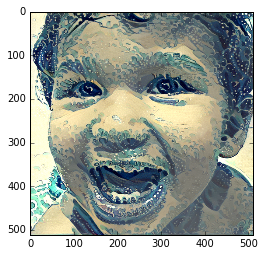

('Current loss value:', 9.2823015e+18)
Iteration 7 completed in 20s
('Start of iteration', 7)


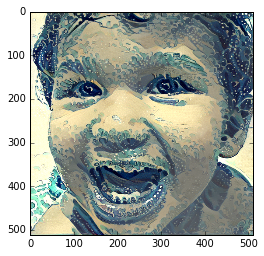

('Current loss value:', 7.8456015e+18)
Iteration 8 completed in 20s
('Start of iteration', 8)


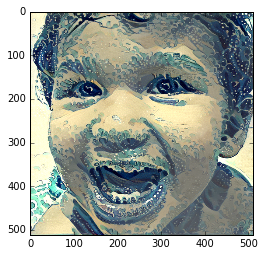

('Current loss value:', 6.8232443e+18)
Iteration 9 completed in 21s
('Start of iteration', 9)


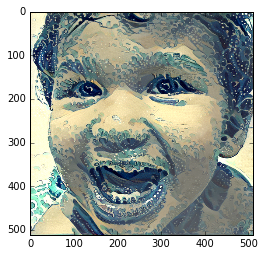

('Current loss value:', 6.147425e+18)
Iteration 10 completed in 21s


In [110]:
# Initialize combination image randomly and run algorithm
# x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.
x = content_array.copy()

result_imgs = [x]

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    new_x, min_val, info = fmin_l_bfgs_b(evaluator.loss, result_imgs[-1].flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    result_imgs.append(new_x)
    plt.imshow(reverse_preprocess(new_x)) # show image
    plt.show()
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i + 1, end_time - start_time))
